# Baseline Throughput Plots

Plot the sum throughput and individual throughputs for a deterministic baseline UAV trajectory (straight line from start to end within time L), using the environment's discrete action space.


In [42]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt

# Add src to path
sys.path.append('../src')

from environment.uav_env import UAVEnvironment
from utils.baseline_policy import choose_greedy_action_to_goal

np.random.seed(42)


In [43]:
def run_baseline_episode(env: UAVEnvironment, distance_tolerance: float = 0.0, target_duration: float = 200.0):
    """
    运行基线episode，UAV飞到终点后停留收集throughput，直到达到目标时长
    
    Args:
        env: UAV环境
        distance_tolerance: 到达终点的距离容忍度
        target_duration: 目标持续时间（秒），默认200秒
    """
    obs, info = env.reset()
    done = False
    sum_throughput_history = []  # per-step total (sum across users)
    individual_hist = []         # per-step per-user
    channel_quality = []         # 监控信道质量
    step_count = 0
    reached_goal = False
    goal_reached_step = None
    
    # 计算目标步数（target_duration秒 / time_step）
    target_steps = int(target_duration / env.time_step)
    
    print(f"Target duration: {target_duration}s, Target steps: {target_steps}, Time step: {env.time_step}s")

    while step_count < target_steps:
        uav_pos = np.array(info['uav_position'])
        end_pos = np.array(info['end_position'])
        
        # 检查是否已到达终点
        distance_to_goal = np.linalg.norm(uav_pos[:2] - end_pos[:2])
        if not reached_goal and distance_to_goal <= distance_tolerance:
            reached_goal = True
            goal_reached_step = step_count
            print(f"Goal reached at step {step_count} (time: {step_count * env.time_step:.1f}s)")
        
        # 选择动作：如果还没到终点就导航，如果已到终点就停留
        if not reached_goal:
            action = choose_greedy_action_to_goal(uav_pos, end_pos, distance_tolerance)
        else:
            action = 4  # Hover action - 停留在终点收集throughput
        
        # 执行动作
        obs, reward, terminated, truncated, info = env.step(action)
        
        # 记录throughput数据
        sum_throughput_history.append(info['throughput'])
        indiv = info.get('individual_throughputs')
        if indiv is None:
            indiv = []
        individual_hist.append(np.array(indiv, dtype=float))

        # 监控信道质量
        user_positions = info['user_positions']
        distances = [np.linalg.norm(uav_pos - np.array(up)) for up in user_positions]
        channel_quality.append(distances)

        step_count += 1
        
        # 如果环境自然结束但还没达到目标时长，继续运行
        if (terminated or truncated) and step_count < target_steps:
            print(f"Environment terminated early at step {step_count}, continuing data collection...")
            # 这里可以选择重置环境或继续记录数据
            # 为简单起见，我们继续记录当前位置的throughput
    
    trajectory = env.get_trajectory()
    
    # Pad individual history if any step had missing values 
    max_users = max((len(x) for x in individual_hist), default=0)
    if max_users > 0:
        padded = []
        for x in individual_hist:
            if len(x) < max_users:
                y = np.zeros(max_users, dtype=float)
                y[:len(x)] = x
                padded.append(y)
            else:
                padded.append(x)
        individual_hist = np.vstack(padded)
    else:
        individual_hist = np.zeros((len(sum_throughput_history), 0), dtype=float)
    
    # 调试信息
    print("User positions:")
    print(env.get_user_positions())

    print("UAV trajectory summary:")
    traj = env.get_trajectory()
    print(f"Start: {traj[0]}")
    print(f"End: {traj[-1]}")
    if goal_reached_step is not None:
        print(f"Goal reached at: {traj[goal_reached_step]} (step {goal_reached_step})")
    print(f"Total steps: {len(traj)}, Target steps: {target_steps}")
    print(f"Total simulation time: {len(sum_throughput_history) * env.time_step:.1f}s")

    return trajectory, sum_throughput_history, individual_hist, goal_reached_step


In [44]:
# Configure environment
env = UAVEnvironment(
    env_size=(100, 100, 50),
    num_users=2,
    num_antennas=8,
    start_position=(0, 0, 50),
    end_position=(80, 80, 50),
    flight_time=200.0,
    time_step=0.1,
    transmit_power=0.5,
    path_loss_exponent=2.5,
    noise_power=-100.0,
    fixed_users=True,
    seed=42
)


In [45]:
# Run deterministic baseline episode with 200s duration
env.set_transmit_strategy(beamforming_method='mrt', power_strategy='equal')
traj, thr_hist, indiv_hist, goal_step = run_baseline_episode(env, distance_tolerance=1.0, target_duration=200.0)
sum_thr_cum = np.cumsum(thr_hist)

# Create time axis for plotting
time_axis = np.arange(len(thr_hist)) * env.time_step


Target duration: 200.0s, Target steps: 2000, Time step: 0.1s
Environment terminated early at step 49, continuing data collection...
Environment terminated early at step 50, continuing data collection...
Environment terminated early at step 51, continuing data collection...
Environment terminated early at step 52, continuing data collection...
Environment terminated early at step 53, continuing data collection...
Environment terminated early at step 54, continuing data collection...
Environment terminated early at step 55, continuing data collection...
Environment terminated early at step 56, continuing data collection...
Environment terminated early at step 57, continuing data collection...
Environment terminated early at step 58, continuing data collection...
Environment terminated early at step 59, continuing data collection...
Environment terminated early at step 60, continuing data collection...
Environment terminated early at step 61, continuing data collection...
Environment term

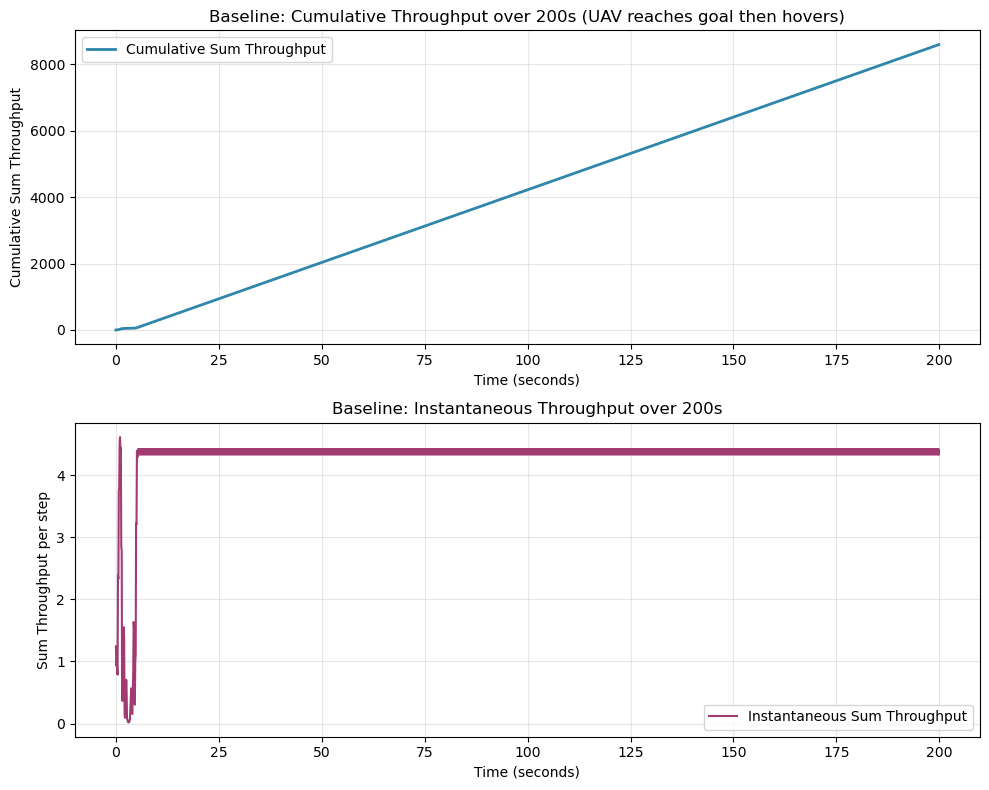


=== 200-Second Baseline Summary ===
Total simulation time: 200.0 seconds
Total cumulative throughput: 8595.06
Average throughput per second: 42.975


In [46]:
# Plot 1: Sum throughput over time (both time and steps)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Cumulative throughput vs time
ax1.plot(time_axis, sum_thr_cum, label='Cumulative Sum Throughput', linewidth=2, color='#2E86AB')
if goal_step is not None:
    goal_time = goal_step * env.time_step
    ax1.axvline(x=goal_time, color='red', linestyle='--', linewidth=2, 
                label=f'Goal Reached (t={goal_time:.1f}s)')
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Cumulative Sum Throughput')
ax1.set_title('Baseline: Cumulative Throughput over 200s (UAV reaches goal then hovers)')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Instantaneous throughput vs time
ax2.plot(time_axis, thr_hist, label='Instantaneous Sum Throughput', linewidth=1.5, color='#A23B72')
if goal_step is not None:
    ax2.axvline(x=goal_time, color='red', linestyle='--', linewidth=2, 
                label=f'Goal Reached (t={goal_time:.1f}s)')
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Sum Throughput per step')
ax2.set_title('Baseline: Instantaneous Throughput over 200s')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n=== 200-Second Baseline Summary ===")
print(f"Total simulation time: {len(thr_hist) * env.time_step:.1f} seconds")
print(f"Total cumulative throughput: {sum_thr_cum[-1]:.2f}")
print(f"Average throughput per second: {sum_thr_cum[-1] / (len(thr_hist) * env.time_step):.3f}")
if goal_step is not None:
    print(f"Goal reached at: {goal_time:.1f}s (step {goal_step})")
    print(f"Throughput before reaching goal: {sum_thr_cum[goal_step]:.2f}")
    print(f"Throughput after reaching goal: {sum_thr_cum[-1] - sum_thr_cum[goal_step]:.2f}")
    print(f"Hover duration: {(len(thr_hist) - goal_step) * env.time_step:.1f}s")


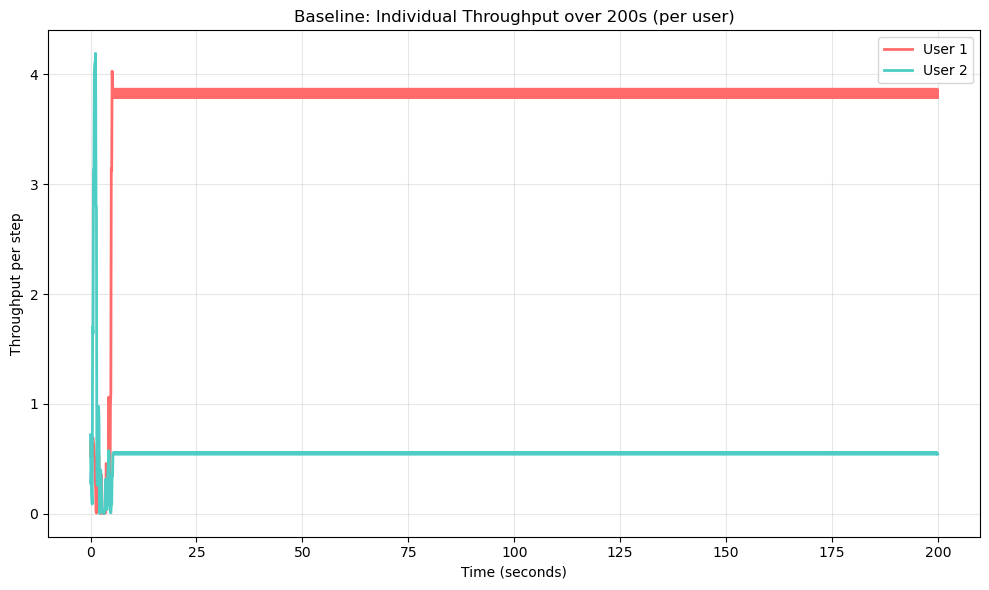


=== Individual User Statistics (200s) ===
User 1: Total=7482.49, Average=3.7412 per step
User 2: Total=1112.57, Average=0.5563 per step
Jain's Fairness Index: 0.645
User throughput ratio: 0.149 (User2/User1)


In [47]:
# Plot 2: Individual throughput over time (per-user per-step)
plt.figure(figsize=(10,6))
if indiv_hist.shape[1] == 0:
    plt.text(0.5, 0.5, 'No individual throughput available', ha='center', va='center')
else:
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57', '#FF9FF3']
    for u in range(indiv_hist.shape[1]):
        plt.plot(time_axis, indiv_hist[:, u], label=f'User {u+1}', 
                linewidth=2, color=colors[u % len(colors)])
    
    # Add goal reached line
    if goal_step is not None:
        goal_time = goal_step * env.time_step
        plt.axvline(x=goal_time, color='red', linestyle='--', linewidth=2, 
                    label=f'Goal Reached (t={goal_time:.1f}s)')

plt.xlabel('Time (seconds)')
plt.ylabel('Throughput per step')
plt.title('Baseline: Individual Throughput over 200s (per user)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Calculate and print individual user statistics
if indiv_hist.shape[1] > 0:
    print(f"\n=== Individual User Statistics (200s) ===")
    for u in range(indiv_hist.shape[1]):
        user_total = np.sum(indiv_hist[:, u])
        user_avg = np.mean(indiv_hist[:, u])
        print(f"User {u+1}: Total={user_total:.2f}, Average={user_avg:.4f} per step")
    
    # Fairness analysis
    user_totals = np.sum(indiv_hist, axis=0)
    if len(user_totals) > 1 and np.sum(user_totals) > 0:
        # Jain's fairness index
        fairness = (np.sum(user_totals) ** 2) / (len(user_totals) * np.sum(user_totals ** 2))
        print(f"Jain's Fairness Index: {fairness:.3f}")
        print(f"User throughput ratio: {user_totals[1]/user_totals[0]:.3f} (User2/User1)")


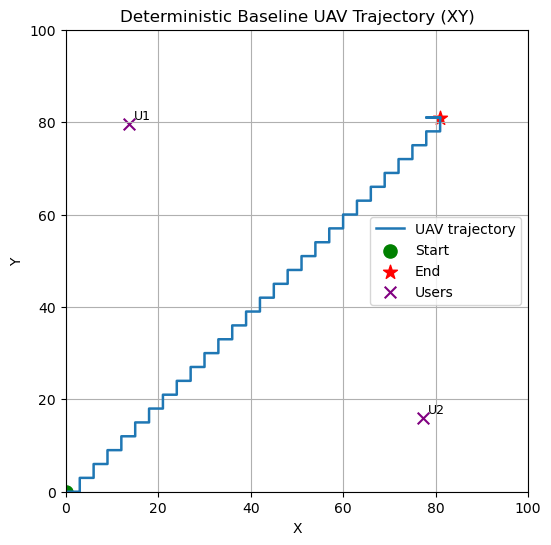

In [48]:
# Plot 3: UAV 2D trajectory with user positions
import numpy as np
import matplotlib.pyplot as plt

traj_arr = np.array(traj)
user_positions = np.array(env.get_user_positions())

plt.figure(figsize=(6,6))
plt.plot(traj_arr[:, 0], traj_arr[:, 1], '-', lw=1.8, label='UAV trajectory')
plt.scatter(traj_arr[0, 0], traj_arr[0, 1], c='green', s=90, marker='o', label='Start')
plt.scatter(traj_arr[-1, 0], traj_arr[-1, 1], c='red', s=110, marker='*', label='End')

if user_positions.size > 0:
    plt.scatter(user_positions[:, 0], user_positions[:, 1], c='purple', s=70, marker='x', label='Users')
    for i, (ux, uy, _) in enumerate(user_positions):
        plt.text(ux + 1, uy + 1, f'U{i+1}', fontsize=9)

plt.xlim(0, env.env_size[0])
plt.ylim(0, env.env_size[1])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Deterministic Baseline UAV Trajectory (XY)')
plt.grid(True)
plt.legend()
plt.show()


In [49]:
# 对比 equal vs proportional 策略的差异
print("=== 对比 Equal vs Proportional 策略 ===")

# 运行 equal 策略 (200s)
env.set_transmit_strategy(power_strategy='equal')
traj_equal, thr_equal, indiv_equal, goal_equal = run_baseline_episode(env, target_duration=200.0)

# 运行 proportional 策略 (200s)
env.set_transmit_strategy(power_strategy='proportional')
traj_prop, thr_prop, indiv_prop, goal_prop = run_baseline_episode(env, target_duration=200.0)

# 运行 water_filling 策略 (200s)
env.set_transmit_strategy(power_strategy='water_filling')
traj_w, thr_w, indiv_w, goal_w = run_baseline_episode(env, target_duration=200.0)


# 对比关键步骤的差异
key_steps = [0, 5, 10, 15, 20, 25]  # 选择几个关键步骤
print("\n关键步骤的个体吞吐量对比:")
print("Step | Equal策略 | Proportional策略 | Water Filling策略")
print("     | User1 User2 | User1 User2 | User1 User2")
print("-" * 40)

for step in key_steps:
    if step < len(indiv_equal) and step < len(indiv_prop):
        equal_users = indiv_equal[step]
        prop_users = indiv_prop[step]
        w_users = indiv_w[step]
        print(f"{step:4d} | {equal_users[0]:6.3f} {equal_users[1]:6.3f} | {prop_users[0]:6.3f} {prop_users[1]:6.3f} | {w_users[0]:6.3f} {w_users[1]:6.3f}")

# 计算总差异
total_diff = np.sum(np.abs(np.array(thr_equal) - np.array(thr_prop)))
print(f"\n总吞吐量差异: {total_diff:.3f}")

# 计算用户间公平性差异
def calculate_fairness(throughputs):
    if len(throughputs) == 0 or np.sum(throughputs) == 0:
        return 0
    return (np.sum(throughputs) ** 2) / (len(throughputs) * np.sum(throughputs ** 2))

equal_fairness = [calculate_fairness(indiv_equal[i]) for i in range(len(indiv_equal))]
prop_fairness = [calculate_fairness(indiv_prop[i]) for i in range(len(indiv_prop))]

avg_equal_fairness = np.mean(equal_fairness)
avg_prop_fairness = np.mean(prop_fairness)

print(f"Equal策略平均公平性: {avg_equal_fairness:.3f}")
print(f"Proportional策略平均公平性: {avg_prop_fairness:.3f}")
print(f"公平性差异: {avg_equal_fairness - avg_prop_fairness:.3f}")

=== 对比 Equal vs Proportional 策略 ===
Target duration: 200.0s, Target steps: 2000, Time step: 0.1s
Environment terminated early at step 49, continuing data collection...
Environment terminated early at step 50, continuing data collection...
Environment terminated early at step 51, continuing data collection...
Environment terminated early at step 52, continuing data collection...
Environment terminated early at step 53, continuing data collection...
Environment terminated early at step 54, continuing data collection...
Environment terminated early at step 55, continuing data collection...
Environment terminated early at step 56, continuing data collection...
Environment terminated early at step 57, continuing data collection...
Environment terminated early at step 58, continuing data collection...
Environment terminated early at step 59, continuing data collection...
Environment terminated early at step 60, continuing data collection...
Environment terminated early at step 61, continuing

Target duration: 200.0s, Target steps: 2000, Time step: 0.1s
Environment terminated early at step 49, continuing data collection...
Environment terminated early at step 50, continuing data collection...
Environment terminated early at step 51, continuing data collection...
Environment terminated early at step 52, continuing data collection...
Environment terminated early at step 53, continuing data collection...
Environment terminated early at step 54, continuing data collection...
Environment terminated early at step 55, continuing data collection...
Environment terminated early at step 56, continuing data collection...
Environment terminated early at step 57, continuing data collection...
Environment terminated early at step 58, continuing data collection...
Environment terminated early at step 59, continuing data collection...
Environment terminated early at step 60, continuing data collection...
Environment terminated early at step 61, continuing data collection...
Environment term

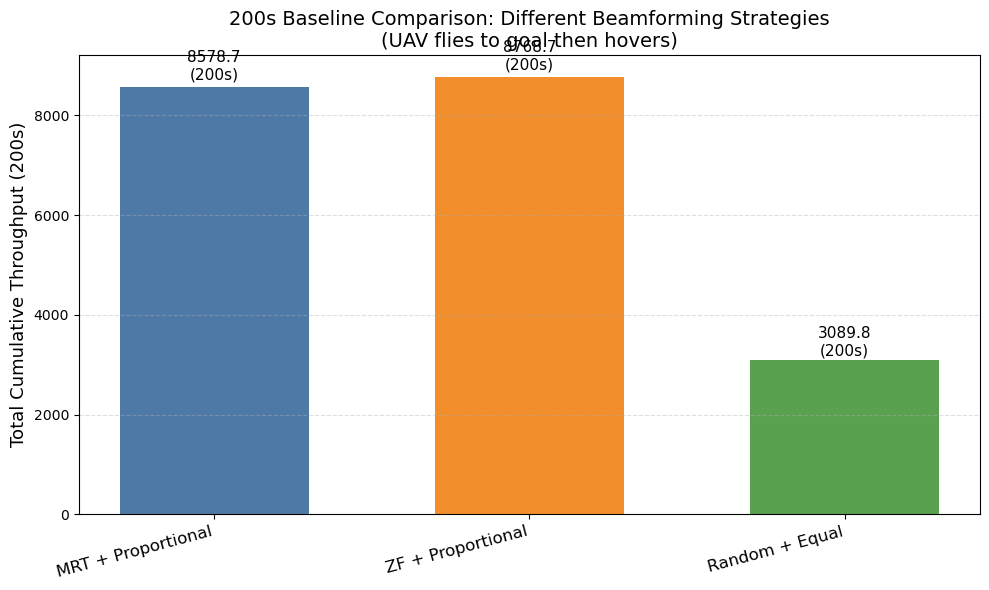


=== 200s Baseline Comparison Summary ===
MRT + Proportional  : Total= 8578.7, Time=  200s, Avg Rate=42.894/s
ZF + Proportional   : Total= 8768.7, Time=  200s, Avg Rate=43.843/s
Random + Equal      : Total= 3089.8, Time=  200s, Avg Rate=15.449/s


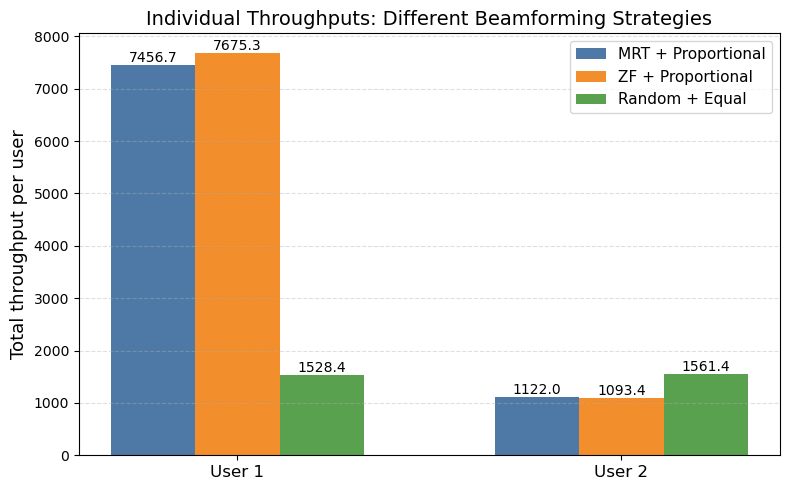

In [50]:
# Bar plots: Compare optimized-signal vs randomized-beamformers on deterministic path
import numpy as np
import matplotlib.pyplot as plt

# Helper to run one scenario and summarize
def run_and_summarize(env, beamforming_method, power_strategy, label, target_duration=200.0):
    env.set_transmit_strategy(beamforming_method=beamforming_method, power_strategy=power_strategy)
    traj_i, thr_hist_i, indiv_hist_i, goal_i = run_baseline_episode(env, target_duration=target_duration)
    total_sum = float(np.sum(thr_hist_i))
    indiv_totals = np.sum(indiv_hist_i, axis=0) if indiv_hist_i.size else np.array([])
    return {
        'label': label,
        'total_sum': total_sum,
        'indiv_totals': indiv_totals,
        'K': len(indiv_totals),
        'goal_step': goal_i,
        'simulation_time': len(thr_hist_i) * env.time_step
    }

results = []

# 重新整理画图部分，增加颜色区分、数值标注、风格美化

# 重新运行三种策略
results = []

res_mrt_prop = run_and_summarize(env, beamforming_method='mrt', power_strategy='proportional',
                                 label='MRT + Proportional')
results.append(res_mrt_prop)

res_zf_prop = run_and_summarize(env, beamforming_method='zf', power_strategy='proportional',
                                label='ZF + Proportional')
results.append(res_zf_prop)

res_rand_eq = run_and_summarize(env, beamforming_method='random', power_strategy='equal',
                                label='Random + Equal')
results.append(res_rand_eq)

# 颜色设置
bar_colors = ['#4e79a7', '#f28e2b', '#59a14f']

# 总吞吐量柱状图 (200秒基线比较)
plt.figure(figsize=(10,6))
labels = [r['label'] for r in results]
values = [r['total_sum'] for r in results]
simulation_times = [r['simulation_time'] for r in results]
bars = plt.bar(range(len(values)), values, color=bar_colors[:len(values)], width=0.6)

# 在柱子上标注数值
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + height*0.01, 
             f"{height:.1f}\n({simulation_times[i]:.0f}s)", 
             ha='center', va='bottom', fontsize=11)

plt.xticks(range(len(values)), labels, rotation=15, ha='right', fontsize=12)
plt.ylabel('Total Cumulative Throughput (200s)', fontsize=13)
plt.title('200s Baseline Comparison: Different Beamforming Strategies\n(UAV flies to goal then hovers)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Print comparison summary
print(f"\n=== 200s Baseline Comparison Summary ===")
for r in results:
    print(f"{r['label']:20s}: Total={r['total_sum']:7.1f}, Time={r['simulation_time']:5.0f}s, "
          f"Avg Rate={r['total_sum']/r['simulation_time']:6.3f}/s")

# 各用户吞吐量分组柱状图
K = max((r['K'] for r in results), default=0)
if K > 0:
    x = np.arange(K)
    width = 0.22
    plt.figure(figsize=(8,5))
    for idx, r in enumerate(results):
        vals = r['indiv_totals']
        # pad if some runs had fewer users reported
        if len(vals) < K:
            tmp = np.zeros(K)
            tmp[:len(vals)] = vals
            vals = tmp
        bars = plt.bar(x + (idx - (len(results)-1)/2)*width, vals, width=width, 
                       label=r['label'], color=bar_colors[idx % len(bar_colors)])
        # 在柱子上标注数值
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height + 0.2, f"{height:.1f}", 
                     ha='center', va='bottom', fontsize=10)
    plt.xticks(x, [f'User {i+1}' for i in range(K)], fontsize=12)
    plt.ylabel('Total throughput per user', fontsize=13)
    plt.title('Individual Throughputs: Different Beamforming Strategies', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()
else:
    print('No individual throughput available to plot.')


In [51]:
# Additional analysis: Compare moving vs hovering phases
print(f"\n=== Movement vs Hovering Analysis ===")

# Analyze the MRT + Proportional case (best performing)
env.set_transmit_strategy(beamforming_method='mrt', power_strategy='proportional')
traj_analysis, thr_analysis, indiv_analysis, goal_analysis = run_baseline_episode(env, target_duration=200.0)

if goal_analysis is not None:
    # Split data into movement and hovering phases
    movement_thr = thr_analysis[:goal_analysis]
    hovering_thr = thr_analysis[goal_analysis:]
    
    movement_indiv = indiv_analysis[:goal_analysis, :]
    hovering_indiv = indiv_analysis[goal_analysis:, :]
    
    print(f"Movement phase (0 to {goal_analysis * env.time_step:.1f}s):")
    print(f"  Steps: {len(movement_thr)}")
    print(f"  Total throughput: {np.sum(movement_thr):.2f}")
    print(f"  Average per step: {np.mean(movement_thr):.4f}")
    
    print(f"Hovering phase ({goal_analysis * env.time_step:.1f}s to 200s):")
    print(f"  Steps: {len(hovering_thr)}")
    print(f"  Total throughput: {np.sum(hovering_thr):.2f}")
    print(f"  Average per step: {np.mean(hovering_thr):.4f}")
    
    improvement_ratio = np.mean(hovering_thr) / np.mean(movement_thr)
    print(f"Hovering vs Movement throughput ratio: {improvement_ratio:.2f}x")
    
    # Plot movement vs hovering comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Box plot comparison
    ax1.boxplot([movement_thr, hovering_thr], labels=['Movement', 'Hovering'])
    ax1.set_ylabel('Instantaneous Throughput')
    ax1.set_title('Throughput Distribution: Movement vs Hovering')
    ax1.grid(True, alpha=0.3)
    
    # Time series with phases marked
    time_axis_analysis = np.arange(len(thr_analysis)) * env.time_step
    ax2.plot(time_axis_analysis, thr_analysis, linewidth=1.5, color='#2E86AB')
    ax2.axvline(x=goal_analysis * env.time_step, color='red', linestyle='--', linewidth=2)
    ax2.fill_between(time_axis_analysis[:goal_analysis], 0, thr_analysis[:goal_analysis], 
                     alpha=0.3, color='orange', label='Movement Phase')
    ax2.fill_between(time_axis_analysis[goal_analysis:], 0, thr_analysis[goal_analysis:], 
                     alpha=0.3, color='green', label='Hovering Phase')
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Instantaneous Throughput')
    ax2.set_title('Throughput Timeline: Movement vs Hovering Phases')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Goal was not reached during simulation")



=== Movement vs Hovering Analysis ===
Target duration: 200.0s, Target steps: 2000, Time step: 0.1s
Environment terminated early at step 49, continuing data collection...
Environment terminated early at step 50, continuing data collection...
Environment terminated early at step 51, continuing data collection...
Environment terminated early at step 52, continuing data collection...
Environment terminated early at step 53, continuing data collection...
Environment terminated early at step 54, continuing data collection...
Environment terminated early at step 55, continuing data collection...
Environment terminated early at step 56, continuing data collection...
Environment terminated early at step 57, continuing data collection...
Environment terminated early at step 58, continuing data collection...
Environment terminated early at step 59, continuing data collection...
Environment terminated early at step 60, continuing data collection...
Environment terminated early at step 61, continu